In [1]:
!pip install monai
!pip install natsort

In [2]:
import os
import random
import shutil
import tempfile
import time
import numpy as np 
import matplotlib.pyplot as plt

from monai.data import DataLoader, decollate_batch, Dataset, CacheDataset
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import UNet, SegResNet
from monai.transforms import (
    Activations,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    AsDiscrete,
    Resized,

)

import torch
from pathlib import Path
from natsort import natsorted
from tqdm.notebook import tqdm

In [3]:
class cfg: 
    base_path = Path('/root/Data/BraTS2020_converted')
    image_path = base_path / "image"
    label_path = base_path / "label"
    seed = 2023
    max_epochs = 400
    val_interval =1
    in_channels=4
    out_channels=3
    save_dir = Path('/content/drive/MyDrive/Model/Brats')
    

In [4]:
train_data_dicts = []

image_files = [cfg.image_path / file_path for file_path in sorted(os.listdir(cfg.image_path))][:-30]


for image_file in image_files:
    match_number = image_file.name.split('_')[-2]
    label_file = cfg.label_path / f"volume_{match_number}_mask.nii"

    # only add match 
    if os.path.exists(label_file):
        train_data_dicts.append({"image": str(image_file), "label": str(label_file)})
        
print(f"the length of match is {len(train_data_dicts)}")

the length of match is 339


In [5]:
print(f"the length of train dataset is {len(train_data_dicts)}")
print(train_data_dicts[195])

the length of train dataset is 339
{'image': '/root/Data/BraTS2020_converted/image/volume_277_image.nii', 'label': '/root/Data/BraTS2020_converted/label/volume_277_mask.nii'}


In [6]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert input channels to specific output channels using PyTorch tensors.

    Input Dimension: (W, H, D, C(Channel)) 
    Input Channel Description:
        0: 'Necrotic (NEC)' unique (0, 1)
        1: 'Edema (ED)' unique (0, 1)
        2: 'Tumour (ET)' unique (0, 1)

    Output Dimension: (C(Channel), W, H, D)
    Output Channel Description:
        0: TC (Tumor core)
        1: WT (Whole tumor)
        2: ET (Enhancing tumor)
    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            # Convert data to PyTorch tensor if not already one
            data_tensor = data[key]

            necrotic = data_tensor[..., 0]
            edema = data_tensor[..., 1]
            enhancing = data_tensor[..., 2]

            # Compute TC: necrotic and enhancing tumor areas (logical OR)
            tc = torch.logical_or(necrotic, enhancing)

            # Compute WT: all tumor areas (logical OR among all channels)
            wt = torch.logical_or(torch.logical_or(necrotic, edema), enhancing)

            # Combine channels into a new tensor with dimensions (C, W, H, D)
            d[key] = torch.stack([tc, wt, enhancing], dim=0)

        return d


In [7]:
# Training transform
train_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Resized(keys=["image"], spatial_size=[128, 128, 80], mode="bilinear"),
        Resized(keys=["label"], spatial_size=[128, 128, 80], mode="nearest"),
    ]
)

# Validation transform
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Resized(keys=["image"], spatial_size=[128, 128, 80], mode="bilinear"),
        Resized(keys=["label"], spatial_size=[128, 128, 80], mode="nearest"),
    ]
)

In [8]:
from sklearn.model_selection import train_test_split
train_dict, valid_dict = train_test_split(train_data_dicts, test_size=0.2, random_state=2023)

In [9]:
# Define train and validation datasets with caching
train_dataset = CacheDataset(data=train_dict, transform=train_transform, cache_rate=0.1, num_workers=1)
valid_dataset = CacheDataset(data=valid_dict, transform=val_transform, cache_rate=0.2, num_workers=1)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=1)
val_loader = DataLoader(valid_dataset, batch_size=3, shuffle=False, num_workers=1)

Loading dataset: 100%|██████████| 13/13 [00:45<00:00,  3.48s/it]


image shape: torch.Size([4, 128, 128, 80])


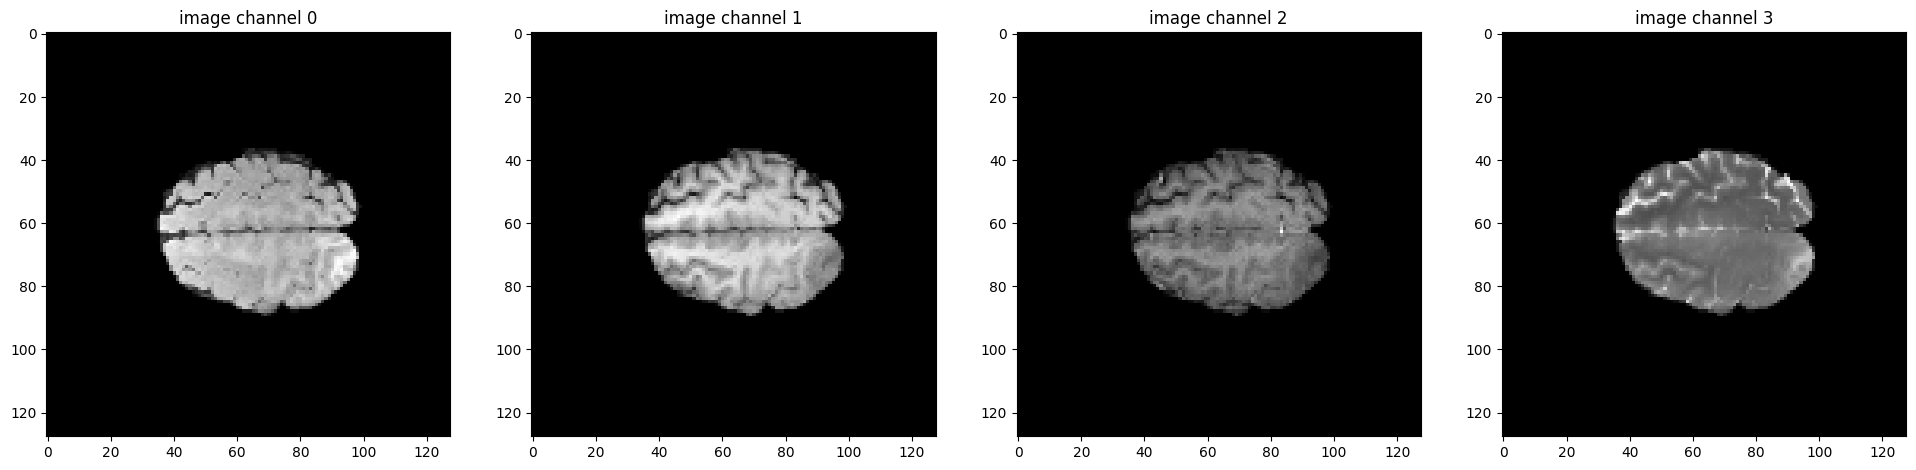

label shape: torch.Size([3, 128, 128, 80])


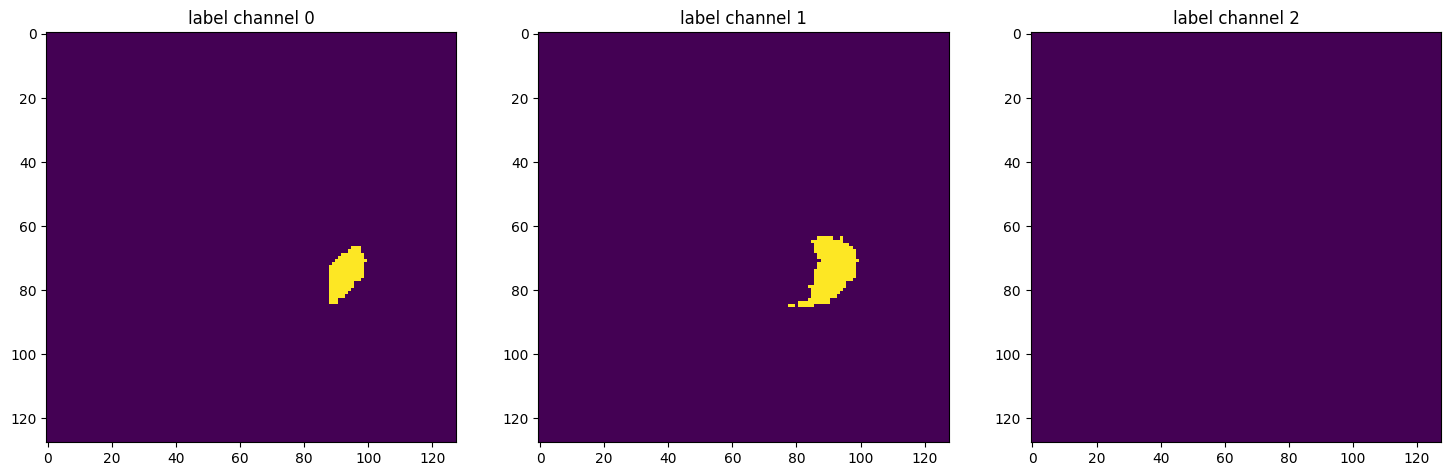

In [10]:
val_data_example = valid_dataset[2]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example["image"][i, :, :, 60].detach().cpu(), cmap="gray")
plt.show()

# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(val_data_example["label"][i, :, :, 60].detach().cpu())
plt.show()

In [11]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(cfg.seed)

In [12]:
val_interval = 1
VAL_AMP = True

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=4,
    out_channels=3,
    dropout_prob=0.2,
).cuda()
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])



# define inference method
def inference(input):
    def _compute(input):
        # Direct inference without sliding window
        return model(input)

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

In [13]:

best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()

for epoch in range(cfg.max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"Epoch {epoch + 1}/{cfg.max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    # Use tqdm for progress bar in training loop
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{cfg.max_epochs}", unit="batch") as pbar:
        for batch_data in train_loader:
            step_start = time.time()
            step += 1
            inputs, labels = batch_data["image"].to('cuda'), batch_data["label"].to('cuda')
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            epoch_loss += loss.item()
            pbar.set_postfix({"train_loss": loss.item(), "step_time": f"{(time.time() - step_start):.4f}s"})
            pbar.update(1)
    
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"Epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % cfg.val_interval == 0:
        model.eval()
        with torch.no_grad():
            # Use tqdm for progress bar in validation loop
            with tqdm(total=len(val_loader), desc="Validation", unit="batch") as pbar_val:
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to('cuda'),
                        val_data["label"].to('cuda')
                    )
                    # Perform inference     
                    val_outputs = inference(val_inputs)

                    # Apply post-transformation and decollate batch
                    val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]

                    # Calculate dice metrics
                    dice_metric(y_pred=val_outputs, y=val_labels)
                    dice_metric_batch(y_pred=val_outputs, y=val_labels)
                    pbar_val.update(1)

                metric = dice_metric.aggregate().item()
                metric_values.append(metric)
                metric_batch = dice_metric_batch.aggregate()
                metric_tc = metric_batch[0].item()
                metric_values_tc.append(metric_tc)
                metric_wt = metric_batch[1].item()
                metric_values_wt.append(metric_wt)
                metric_et = metric_batch[2].item()
                metric_values_et.append(metric_et)
                dice_metric.reset()
                dice_metric_batch.reset()

                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    best_metrics_epochs_and_time[0].append(best_metric)
                    best_metrics_epochs_and_time[1].append(best_metric_epoch)
                    best_metrics_epochs_and_time[2].append(time.time() - total_start)
                    torch.save(
                        model.state_dict(),
                        str(cfg.save_dir / f"best_metric_model_{best_metric:.4f}.pth"),
                    )
                    print("Saved new best metric model")
                print(
                    f"Current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                    f"\nBest mean dice: {best_metric:.4f}"
                    f" at epoch: {best_metric_epoch}"
                )
    print(f"Time consuming for epoch {epoch + 1} is: {(time.time() - epoch_start):.4f} seconds")

total_time = time.time() - total_start
print(f"Total training time: {total_time:.4f} seconds")

----------
Epoch 1/400


Epoch 1/400:   0%|          | 0/46 [00:00<?, ?batch/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1 average loss: 0.9363


Validation:   0%|          | 0/23 [00:00<?, ?batch/s]

Saved new best metric model
Current epoch: 1 current mean dice: 0.2744 tc: 0.2328 wt: 0.4864 et: 0.0805
Best mean dice: 0.2744 at epoch: 1
Time consuming for epoch 1 is: 1049.0465 seconds
----------
Epoch 2/400


Epoch 2/400:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 2 average loss: 0.9179


Validation:   0%|          | 0/23 [00:00<?, ?batch/s]

Saved new best metric model
Current epoch: 2 current mean dice: 0.3269 tc: 0.2587 wt: 0.5598 et: 0.1386
Best mean dice: 0.3269 at epoch: 2
Time consuming for epoch 2 is: 1031.1701 seconds
----------
Epoch 3/400


Epoch 3/400:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 3 average loss: 0.9106


Validation:   0%|          | 0/23 [00:00<?, ?batch/s]

Saved new best metric model
Current epoch: 3 current mean dice: 0.3655 tc: 0.3012 wt: 0.6091 et: 0.1572
Best mean dice: 0.3655 at epoch: 3
Time consuming for epoch 3 is: 1060.8527 seconds
----------
Epoch 4/400


Epoch 4/400:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 4 average loss: 0.9046


Validation:   0%|          | 0/23 [00:00<?, ?batch/s]

Saved new best metric model
Current epoch: 4 current mean dice: 0.3865 tc: 0.3185 wt: 0.6365 et: 0.1743
Best mean dice: 0.3865 at epoch: 4
Time consuming for epoch 4 is: 1026.8805 seconds
----------
Epoch 5/400


Epoch 5/400:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 5 average loss: 0.8995


Validation:   0%|          | 0/23 [00:00<?, ?batch/s]

Current epoch: 5 current mean dice: 0.3685 tc: 0.3016 wt: 0.6110 et: 0.1650
Best mean dice: 0.3865 at epoch: 4
Time consuming for epoch 5 is: 1013.3489 seconds
----------
Epoch 6/400


Epoch 6/400:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 6 average loss: 0.8963


Validation:   0%|          | 0/23 [00:00<?, ?batch/s]

Current epoch: 6 current mean dice: 0.3725 tc: 0.3080 wt: 0.6142 et: 0.1663
Best mean dice: 0.3865 at epoch: 4
Time consuming for epoch 6 is: 1016.0585 seconds
----------
Epoch 7/400


Epoch 7/400:   0%|          | 0/46 [00:00<?, ?batch/s]

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()

In [ ]:
model.load_state_dict(torch.load(str(cfg.save_dir / f"best_metric_model_{best_metric}.pth")))
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = valid_dataset[2]["image"].unsqueeze(0).cuda()
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(valid_dataset[2]["image"][i, :, :, 70].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(valid_dataset[2]["label"][i, :, :, 70].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, 70].detach().cpu())
    plt.show()